# Links
- http://tdface.ece.tufts.edu/downloads/TD_RGB_E/
- http://vision.ucsd.edu/~leekc/ExtYaleDatabase/ExtYaleB.html
-> Try the Yale face dataset

# 1.0) data prep - images too large, occupies too much space

In [1]:
import pickle 

import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [3]:
# load saved data 

with open('/blnas/scratch/nripesh/winter_ai_2021_materials/tufts_data/pose_data_resized.pkl', 'rb') as file:
    resized_pose_images = pickle.load(file)

with open('/blnas/scratch/nripesh/winter_ai_2021_materials/tufts_data/emotion_data_resized.pkl', 'rb') as file:
    resized_emotion_images = pickle.load(file)

len(resized_pose_images), len(resized_emotion_images)

(3406, 560)

In [4]:
# IMPORTANT CONCEPT - train / test seperation

import copy

emotion_img_paths = list(resized_emotion_images.keys())
emotion_img_paths[0], resized_emotion_images[emotion_img_paths[0]]

train_sets = ['set_1', 'set_2', 'set_3']
test_sets = ['set_4']

def generate_paired_data(sets, image_paths_and_array, target_total_pairs=2000):
    # organize images by subjects
    # randomly select 1 subject
    # for 1 positive example, sample 1 negative
    # for selected subject, get an example -> select another from same set -> positive
    # get another example from another subject -> negative
    # record index of positive examples, index of negative examples -> as long as not the same pair, okay
    
    # organize by subject
    image_by_subjects = {}
    subjects_all = set()
    for img_path, img in image_paths_and_array.items():
        img_set = img_path.split('/')[-3]
        if img_set not in sets:
            continue
        subject = img_path.split('/')[-2]
        subjects_all.add(subject)
        image_by_subjects.setdefault(subject, []).append(img)
    
    subjects_all = list(subjects_all)
    
    pairs_count = 0
    used_pairs = set()
    
    def check_not_used(new_pair):
        if new_pair in used_pairs:
            return False
        if (new_pair[1], new_pair[0]) in used_pairs:
            return False
        return True
    
    def check_not_same(pair):
        return pair[0] != pair[1]
    
    
    positive_pairs_all = []
    negative_pairs_all = []
    
    while pairs_count < target_total_pairs:
        rand_subject = subjects_all[np.random.choice(len(subjects_all))]
        other_subjects = set(subjects_all).difference(set(rand_subject))        
        assert not other_subjects.intersection(set(rand_subject))

        other_subject_one = list(other_subjects)[np.random.choice(len(other_subjects))]
        rand_subject_i, rand_subject_j = np.random.choice(
            len(image_by_subjects[rand_subject]), 2, replace=False
        )
        other_subject_j = np.random.choice(len(image_by_subjects[other_subject_one]))
        
        positive_pair = (rand_subject_i, rand_subject_j)
        negative_pair = (rand_subject_i, other_subject_j)
        
        if check_not_used(positive_pair) and check_not_used(negative_pair) and check_not_same(positive_pair):
            positive_pairs_all.append(
                (
                    image_by_subjects[rand_subject][rand_subject_i],
                    image_by_subjects[rand_subject][rand_subject_j],
                )
            )
            negative_pairs_all.append(
                (
                    image_by_subjects[rand_subject][rand_subject_i],
                    image_by_subjects[other_subject_one][other_subject_j],
                )
            )
            
            pairs_count += 1
    
    return positive_pairs_all, negative_pairs_all


pose_and_emotion_images = copy.copy(resized_pose_images)
pose_and_emotion_images.update(resized_emotion_images)

# emotion pairs
train_match_pairs_emo, train_no_match_pairs_emo = (
    generate_paired_data(train_sets, resized_emotion_images, target_total_pairs=1500)
)
test_match_pairs_emo, test_no_match_pairs_emo = (
    generate_paired_data(test_sets, resized_emotion_images, target_total_pairs=200)
)

# # pose pairs
# train_match_pairs_pose, train_no_match_pairs_pose = (
#     generate_paired_data(train_sets, resized_pose_images, target_total_pairs=3000)
# )
# test_match_pairs_pose, test_no_match_pairs_pose = (
#     generate_paired_data(test_sets, resized_pose_images, target_total_pairs=1000)
# )

# train_match_pairs.extend(train_match_pairs_pose)
# train_no_match_pairs.extend(train_no_match_pairs_pose)

# test_match_pairs.extend(test_match_pairs_pose)
# test_no_match_pairs.extend(test_no_match_pairs_pose)


# combined_pairs
train_match_pairs, train_no_match_pairs = (
    generate_paired_data(train_sets, pose_and_emotion_images, target_total_pairs=5500)
)
test_match_pairs, test_no_match_pairs = (
    generate_paired_data(test_sets, pose_and_emotion_images, target_total_pairs=1800)
)

train_match_pairs.extend(train_match_pairs_emo)
train_no_match_pairs.extend(train_no_match_pairs_emo)
test_match_pairs.extend(test_match_pairs_emo)
test_no_match_pairs.extend(test_no_match_pairs_emo)

len(train_match_pairs), len(train_no_match_pairs), len(test_match_pairs), len(test_no_match_pairs)


(7000, 7000, 2000, 2000)

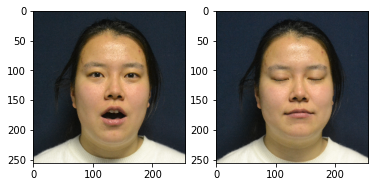

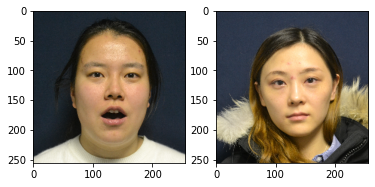

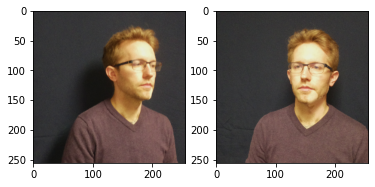

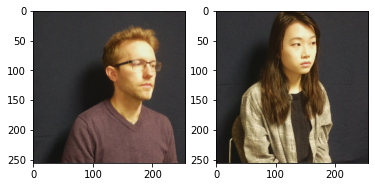

In [5]:
# CONCEPT - always visualize what your data looks like

example_ind = np.random.choice(len(train_match_pairs))

fig, axes = plt.subplots(1, 2)
axes[0].imshow(train_match_pairs[example_ind][0])
axes[1].imshow(train_match_pairs[example_ind][1])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(train_no_match_pairs[example_ind][0])
axes[1].imshow(train_no_match_pairs[example_ind][1])

example_ind = np.random.choice(len(test_match_pairs))

fig, axes = plt.subplots(1, 2)
axes[0].imshow(test_match_pairs[example_ind][0])
axes[1].imshow(test_match_pairs[example_ind][1])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(test_no_match_pairs[example_ind][0])
axes[1].imshow(test_no_match_pairs[example_ind][1])


1.0
1.0


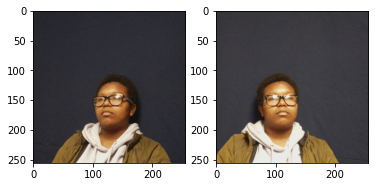

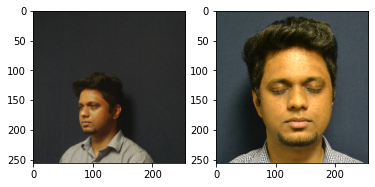

In [14]:
# now vectorize into form easy to train networks

# X_train_a = np.concatenate(
#     (
#         np.array([pair[0] for pair in train_match_pairs]), 
#         np.array([pair[0] for pair in train_no_match_pairs ])
#     )
# ).astype('float32')

# X_train_b = np.concatenate(
#     (
#         np.array([pair[1] for pair in train_match_pairs]), 
#         np.array([pair[1] for pair in train_no_match_pairs])
#     )
# ).astype('float32')

# y_train = np.array(
#     [1] * len(train_match_pairs) + 
#     [0] * len(train_no_match_pairs)
# ).astype('float32')


# X_test_a = np.concatenate(
#     (
#         np.array([pair[0] for pair in test_match_pairs]), 
#         np.array([pair[0] for pair in test_no_match_pairs])
#     )
# ).astype('float32')

# X_test_b = np.concatenate(
#     (
#         np.array([pair[1] for pair in test_match_pairs]), 
#         np.array([pair[1] for pair in test_no_match_pairs])
#     )
# ).astype('float32')

# y_test = np.array(
#     [1] * len(test_match_pairs) + 
#     [0] * len(test_no_match_pairs)
# ).astype('float32')


ind = np.random.choice(len(X_train_a))
print(y_train[ind])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(X_train_a[ind].astype('uint8'))
axes[1].imshow(X_train_b[ind].astype('uint8'))

ind = np.random.choice(len(X_test_a))
print(y_test[ind])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(X_test_a[ind].astype('uint8'))
axes[1].imshow(X_test_b[ind].astype('uint8'))


In [20]:
# CONCEPTS - contrastive loss, embedding and distance, siamese network

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Activation,
    Input, Lambda, Dense, 
    Dropout, Conv2D, MaxPooling2D, 
    Flatten, GlobalAveragePooling2D
)

from tensorflow.keras.models import (
    Sequential,
    Model
)

from SiameseFunctions import (
    euclidean_distance,
    eucl_dist_output_shape,
    contrastive_loss,
    compute_accuracy,
    accuracy,
)

from tensorflow.keras.optimizers import RMSprop, Adam

In [15]:
# CONCEPT: data generators 
from keras.preprocessing.image import ImageDataGenerator


BATCH_SIZE = 8

data_aug = True


if data_aug:
    train_generator = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
#         brightness_range=[0.5, 1.5],
    )
else:
    train_generator = ImageDataGenerator()

val_generator = ImageDataGenerator()

def gen_train_flow():
    train_iterator_a = train_generator.flow(
        X_train_a, 
        y_train, 
        batch_size=BATCH_SIZE,
        seed=42,
    )
    train_iterator_b = train_generator.flow(
        X_train_a, 
        X_train_b, 
        batch_size=BATCH_SIZE,
        seed=42,
    )
    while True:
        X_a = train_iterator_a.next()
        X_b = train_iterator_b.next()
        yield [X_a[0], X_b[1]], X_a[1]
        
        
def gen_val_flow():
    test_iterator_a = val_generator.flow(
        X_test_a, 
        y_test, 
        batch_size=BATCH_SIZE,
        seed=42,
    )
    test_iterator_b = val_generator.flow(
        X_test_a,
        X_test_b, 
        batch_size=BATCH_SIZE,
        seed=42,
    )
    while True:
        X_a = test_iterator_a.next()
        X_b = test_iterator_b.next()
        yield [X_a[0], X_b[1]], X_a[1]



255.0 255.0
4
0.0


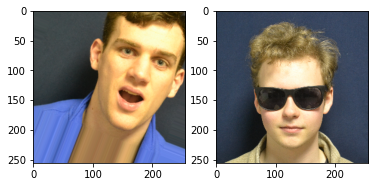

In [17]:
count = 0
for x_ab, yi in gen_train_flow():
    if count == 1:
        break
    count += 1
    rand_ind = np.random.choice(BATCH_SIZE)

print(x_ab[0].max(), x_ab[1].max())
    
fig, axes = plt.subplots(1, 2)
print(rand_ind)
print(yi[rand_ind])
axes[0].imshow(x_ab[0][rand_ind].astype('uint8'))
axes[1].imshow(x_ab[1][rand_ind].astype('uint8'))


255.0 255.0
1
1.0


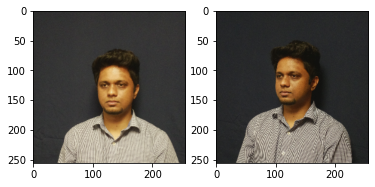

In [18]:
count = 0
for x_ab, yi in gen_val_flow():
    if count == 9:
        break
    count += 1
    rand_ind = np.random.choice(BATCH_SIZE)

print(x_ab[0].max(), x_ab[1].max())
    
fig, axes = plt.subplots(1, 2)
print(rand_ind)
print(yi[rand_ind])
axes[0].imshow(x_ab[0][rand_ind].astype('uint8'))
axes[1].imshow(x_ab[1][rand_ind].astype('uint8'))


In [47]:
# TRAINING

# try mobilenet model with some extra layers

# mobilenet-v3 

from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

NET_SIZE = X_train_a.shape[1]

# input and pre-processing
input_dim = (256, 256, 3)

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)

input_a_processed = preprocess_input(input_a)
input_b_processed = preprocess_input(input_b)

# base mobilenet model
base_model = MobileNetV3Small(
    include_top=False, 
    weights='imagenet'
)
processed_a = base_model(input_a_processed)
processed_b = base_model(input_b_processed)

# add few dense layers
flatten = Flatten()
flattened_a = flatten(processed_a)
flattened_b = flatten(processed_b)

# dense 1
dense_layer_1 = Dense(64, activation='relu')
dense_1_a = dense_layer_1(flattened_a)
dense_1_b = dense_layer_1(flattened_b)

# dense 2
dense_layer_2 = Dense(16, activation='relu')
processed_a = dense_layer_2(dense_1_a)
processed_b = dense_layer_2(dense_1_b)


# set up the distance metric
distance = Lambda(
    euclidean_distance, 
    output_shape=eucl_dist_output_shape
)([processed_a, processed_b])

 
# training set up
mblnet_model = Model(inputs=[input_a, input_b], outputs=[distance])

model_out_path_mblnet = '/blnas/scratch/nripesh/winter_ai_2021_materials/face_match_model_mblnet'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_out_path_mblnet,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    save_best_only=True,
    restore_best_weights=True,
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=3, mode='max'
)

# freeze trainable layer
mblnet_model.layers[2].trainable = False
mblnet_model.summary()




Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3small (Functional)  (None, 1, 1, 1024)   1529968     ['input_7[0][0]',                
                                                                  'input_8[0][0]']          

Epoch 1/6
1750/1750 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.8221INFO:tensorflow:Assets written to: /blnas/scratch/nripesh/winter_ai_2021_materials/face_match_model_mblnet/assets


/home/nripesh_baylabs_io/tf2/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/nripesh_baylabs_io/tf2/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1750/1750 [==============================] - 463s 261ms/step - loss: 0.1327 - accuracy: 0.8221 - val_loss: 0.1607 - val_accuracy: 0.7590
Epoch 2/6
1750/1750 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.8939INFO:tensorflow:Assets written to: /blnas/scratch/nripesh/winter_ai_2021_materials/face_match_model_mblnet/assets


/home/nripesh_baylabs_io/tf2/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/nripesh_baylabs_io/tf2/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1750/1750 [==============================] - 459s 263ms/step - loss: 0.0941 - accuracy: 0.8939 - val_loss: 0.1501 - val_accuracy: 0.7850
Epoch 3/6
1750/1750 [==============================] - ETA: 0s - loss: 0.0805 - accuracy: 0.9159INFO:tensorflow:Assets written to: /blnas/scratch/nripesh/winter_ai_2021_materials/face_match_model_mblnet/assets


/home/nripesh_baylabs_io/tf2/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/nripesh_baylabs_io/tf2/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1750/1750 [==============================] - 453s 259ms/step - loss: 0.0805 - accuracy: 0.9159 - val_loss: 0.1406 - val_accuracy: 0.7987
Epoch 4/6
 732/1750 [===========>..................] - ETA: 3:57 - loss: 0.0752 - accuracy: 0.9261

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1750/1750 [==============================] - 427s 244ms/step - loss: 0.0752 - accuracy: 0.9234 - val_loss: 0.1573 - val_accuracy: 0.7782
Epoch 5/6
1750/1750 [==============================] - 428s 244ms/step - loss: 0.0694 - accuracy: 0.9304 - val_loss: 0.1513 - val_accuracy: 0.7820
Epoch 6/6
1750/1750 [==============================] - 429s 245ms/step - loss: 0.0661 - accuracy: 0.9354 - val_loss: 0.1594 - val_accuracy: 0.7697


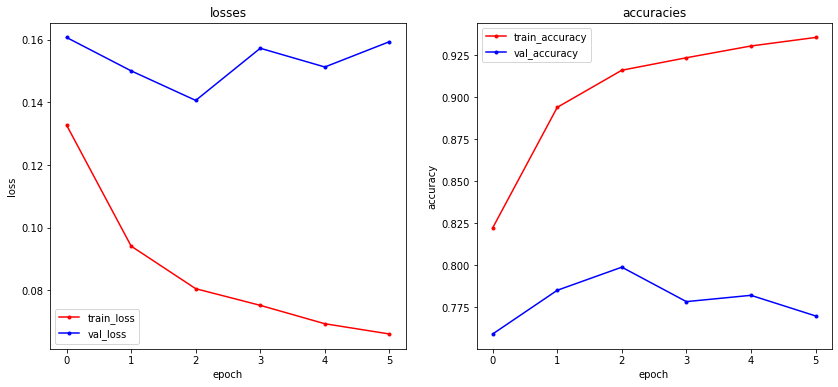

In [48]:
# TRAINING

def plot_history(hist):
    """
    Quick function to plot the history 
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(hist.history['loss'], 'r.-')
    axes[0].plot(hist.history['val_loss'], 'b.-')
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[0].set_title('losses')
    axes[0].legend(['train_loss', 'val_loss'])
    
    axes[1].plot(hist.history['accuracy'], 'r.-')
    axes[1].plot(hist.history['val_accuracy'], 'b.-')
    axes[1].set_ylabel('accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].set_title('accuracies')
    axes[1].legend(['train_accuracy', 'val_accuracy'])
    

steps_per_epoch = int(len(X_train_a) / BATCH_SIZE)
validation_steps = int(len(X_test_a) / BATCH_SIZE)
nb_epochs = 6

mblnet_model.compile(
    loss=contrastive_loss, 
    optimizer=Adam(),
    metrics=[accuracy]
)

hist = mblnet_model.fit(
    gen_train_flow(),
    epochs=nb_epochs,
    validation_data=gen_val_flow(),
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps,
    callbacks=[model_checkpoint_callback, early_stopping],
)

# mblnet_model = tf.keras.models.load_model(model_out_path_mblnet)

plot_history(hist)

1.0 [0.15991427] [ True]


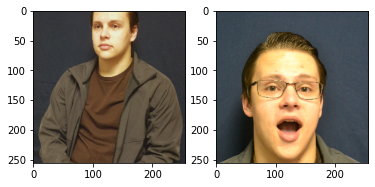

In [49]:
# example on validation data

rand_ind_j = np.random.choice(len(X_test_a))
test_example_a = np.expand_dims(X_test_a[rand_ind_j], 0)
test_example_b = np.expand_dims(X_test_b[rand_ind_j], 0)

test_pred_example_y = mblnet_model.predict((test_example_a, test_example_b))[0]

print(y_test[rand_ind_j], test_pred_example_y, test_pred_example_y < 0.5)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(test_example_a[0].astype('uint8'))
axes[1].imshow(test_example_b[0].astype('uint8'))
a = 2

[[0.28194126]] [[ True]]


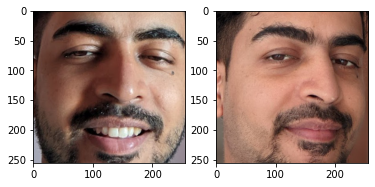

In [72]:
# test with external


test_model = mblnet_model


def get_background_img():
    return np.zeros((256, 256, 3)).astype('float32') + 0.179 * 255

def add_background(img):
    if img.shape[0] >= 256:
        return img
    else:
        x1 = int((256 - img.shape[0]) / 2)
        img_new = get_background_img()
        img_new[x1: x1 + img.shape[0], x1: x1 + img.shape[0]] = img
        return img_new
        

def load_test_images():
    im_by_subjects = {}
    for img_path in glob.glob(
            '/blnas/scratch/nripesh/winter_ai_2021_materials/tufts_data/external_test_set/*.jpg'
    ):
        im = cv2.imread(img_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im_resized = cv2.resize(im, (256, 256)).astype('float32')
        img_w_bgnd = add_background(im_resized)
        subject = img_path.split('/')[-1].split('.jpg')[0][:-1]
        im_by_subjects.setdefault(subject, []).append(img_w_bgnd)
    return im_by_subjects


test_images = load_test_images()

test_subjects = list(test_images.keys())

subject_1 = test_subjects[np.random.choice(len(test_subjects))]
subject_2 = test_subjects[np.random.choice(len(test_subjects))]

ind_i = np.random.choice(2)
ind_j = np.random.choice(2)


test_example_a = np.expand_dims(test_images[subject_1][ind_i], 0)
test_example_b = np.expand_dims(test_images[subject_2][ind_j], 0)

test_example_y = test_model.predict((test_example_a, test_example_b))
predict_out = test_example_y < 0.5
print(test_example_y, predict_out)
    
fig, axes = plt.subplots(1, 2)
axes[0].imshow(test_example_a[0].astype('uint8'))
axes[1].imshow(test_example_b[0].astype('uint8'))

In [ ]:
# quantify fully

from itertools import product

count = 0
correct = 0

for subject_1, subject_2 in product(test_subjects, test_subjects):
    for ind_i in range(2):
        for ind_j in range(2):
            test_example_a = np.expand_dims(test_images[subject_1][ind_i], 0)
            test_example_b = np.expand_dims(test_images[subject_2][ind_j], 0)

            test_example_y = test_model.predict((test_example_a, test_example_b))

            predict_out = test_example_y < 0.5
            count += 1

            if subject_1 == subject_2:
                if predict_out:
                    correct += 1
            if subject_1 != subject_2:
                if not predict_out:
                    correct += 1
                

print(100 * correct / count, count)